In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats

from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import RepeatedStratifiedKFold

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
get_data_path = lambda folders, fname: os.path.normpath(os.environ['DRIVE_PATH'] + '/' + '/'.join(folders) + '/' + fname)

file_path = get_data_path(['SL PRED', 'input', 'gemini'], 'ito_pairs_annotated.csv')
file_path_parrish = get_data_path(['SL PRED', 'input', 'gemini'], 'parrish_pairs_annotated.csv')
figure_path_a = get_data_path(['SL PRED', 'Fig 1'], 'gene_box_plots.png')
figure_path_b = get_data_path(['SL PRED', 'Fig 1'], 'indv_gene_feature_aucs.png')

In [3]:
# load dataframe
df = pd.read_csv(file_path)
df.head()

,genepair,A1,A2,A1_entrez,A2_entrez,DepMap_ID,cell_line,Gemini_FDR,raw_LFC,SL,...,smallest_GO_CC_gene_effect,min_GO_CC_gene_z_effect,max_GO_CC_gene_z_effect,smallest_GO_CC_gene_z_effect,prediction_score,GEMINI,LFC,SL_1,SL_08,SL_06
0,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000022,PATU8988S_PANCREAS,0.998944,0.088856,False,...,-0.104289,-0.021442,0.029952,0.003538,0.012559,0.118768,0.088856,False,False,False
1,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000307,PK1_PANCREAS,0.986587,0.201704,False,...,-0.103074,-0.032004,0.021698,-0.010239,0.012559,0.132501,0.201704,False,False,False
2,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000632,HS944T_SKIN,1.000000,0.069772,False,...,-0.099791,-0.018027,0.022543,-0.000695,0.012559,0.024593,0.069772,False,False,False
3,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000681,A549_LUNG,0.977988,0.379455,False,...,-0.095668,-0.012634,0.034220,0.009562,0.012559,-0.241323,0.379455,False,False,False
4,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000756,GI1_CENTRAL_NERVOUS_SYSTEM,0.999586,-0.077118,False,...,-0.097826,-0.013141,0.044570,0.018164,0.012559,0.299715,-0.077118,False,False,False


In [4]:
# remove NA values
features = ['zMaxExp_A1A2', 'zMinExp_A1A2', 'rMaxExp_A1A2', 'rMinExp_A1A2',
            'z_max_ranked_A1A2', 'z_min_ranked_A1A2', 'max_ranked_A1A2', 'min_ranked_A1A2',
            'max_cn', 'min_cn', 'Protein_Altering', 'Damaging', 'max_seq_id', 'min_seq_id',
            'ranked_BioGRID_ALL', 'ranked_Essentiality_weighted_PPI', 
            'min_GO_ranked_ess', 'max_GO_ranked_ess', 'smallest_GO_ranked_ess',
            'min_GO_CC_ranked_ess', 'max_GO_CC_ranked_ess', 'smallest_GO_CC_ranked_ess',
            'Expression_weighted_PPI', 
            'max_gene_expression', 'min_gene_expression', 'smallest_gene_expression',
            'min_GO_CC_expression', 'max_GO_CC_expression', 'smallest_GO_CC_expression']

target = 'SL_08'

In [5]:
#remove NA values before training the model
df_clean = df.dropna(axis=0, how='any', subset=features + [target]).reset_index(drop=True) 

#summary of the training dataset after removing NA values
print(f"Number of SL pairs: {df_clean[df_clean[target] == True].shape[0]} / {df_clean.shape[0]}")
print(f"Number of non-SL pairs: {df_clean[df_clean[target] == False].shape[0]} / {df_clean.shape[0]}")
print(f'Number of unique gene pairs: {df_clean.genepair.nunique()}')
print(f'Number of unique cell lines: {df_clean.cell_line.nunique()}')
df_clean[:3]

Number of SL pairs: 358 / 41181
Number of non-SL pairs: 40823 / 41181
Number of unique gene pairs: 4161
Number of unique cell lines: 10


,genepair,A1,A2,A1_entrez,A2_entrez,DepMap_ID,cell_line,Gemini_FDR,raw_LFC,SL,...,smallest_GO_CC_gene_effect,min_GO_CC_gene_z_effect,max_GO_CC_gene_z_effect,smallest_GO_CC_gene_z_effect,prediction_score,GEMINI,LFC,SL_1,SL_08,SL_06
0,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000022,PATU8988S_PANCREAS,0.998944,0.088856,False,...,-0.104289,-0.021442,0.029952,0.003538,0.012559,0.118768,0.088856,False,False,False
1,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000307,PK1_PANCREAS,0.986587,0.201704,False,...,-0.103074,-0.032004,0.021698,-0.010239,0.012559,0.132501,0.201704,False,False,False
2,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000632,HS944T_SKIN,1.000000,0.069772,False,...,-0.099791,-0.018027,0.022543,-0.000695,0.012559,0.024593,0.069772,False,False,False


### Individual Feature Analysis: Predictive Power of Genomic Features
### Bar plot

This section visualizes the predictive power (ROC AUC and PR AUC) of individual genomics features such as gene expression, and gene essentiality.
 
The resulting visualization helps identify which features independently contribute most to the prediction of synthetic lethality.

In [6]:
# Define feature metadata using a dictionary
features_dict = [
    {"name": "zMaxExp_A1A2", "label": "Gene zExpression (max)", "category": "expression"},
    {"name": "zMinExp_A1A2", "label": "Gene zExpression (min)", "category": "expression"},
    {"name": "rMaxExp_A1A2", "label": "Gene Expression (max)", "category": "expression"},
    {"name": "rMinExp_A1A2", "label": "Gene Expression (min)", "category": "expression"},
    {"name": "z_max_ranked_A1A2", "label": "Gene zEssentiality (max)", "category": "essentiality"},
    {"name": "z_min_ranked_A1A2", "label": "Gene zEssentiality (min)", "category": "essentiality"},
    {"name": "max_ranked_A1A2", "label": "Gene Essentiality (max)", "category": "essentiality"},
    {"name": "min_ranked_A1A2", "label": "Gene Essentiality (min)", "category": "essentiality"},
    {"name": "max_cn", "label": "Copy Number (max)", "category": "genomic"},
    {"name": "min_cn", "label": "Copy Number (min)", "category": "genomic"},
    {"name": "Protein_Altering", "label": "Protein Altering Mutation", "category": "genomic"},
    {"name": "Damaging", "label": "Damaging Mutation", "category": "genomic"},
    {"name": "max_seq_id", "label": "Sequence Identity", "category": "sequence"}
]

# Extract specific information dynamically if needed
feature_columns = [f["name"] for f in features_dict]
labels = [f["label"] for f in features_dict]
categories = [f["category"] for f in features_dict]

# Target column
target_column = "SL_08"


In [7]:
def calculate_predictive_power(df, feature_columns, target_column, labels, categories):
    data, target = df[feature_columns], df[target_column]
    
    # Define the number of folds for the cross-validation
    n_folds = 5

    # Define the number of repetitions
    n_repeats = 10
    
    # Create a RepeatedStratifiedKFold object
    rskf = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=42)

    # Initialize lists to store the average ROC-AUC and average precision values for each feature
    mean_aucs = []
    mean_prs = []

    # Calculate baseline PR AUC
    baseline_pr_auc = np.sum(target) / len(target)
    print(f'Baseline PR AUC: {baseline_pr_auc:.4f}')

    # Iterate over each feature
    for feature_name in feature_columns:
        # Get the feature data
        feature = data[feature_name].values
        aucs = []
        aps = []

        # Calculate the ROC AUC for both positive and negative directions
        pos_direction = roc_auc_score(target, feature)
        neg_direction = roc_auc_score(target, -feature)

        # If the ROC AUC is higher for the negative direction, then flip the feature
        if neg_direction > pos_direction:
            feature = -feature

        # Perform cross-validation
        for train_index, test_index in rskf.split(feature, target):
            train_target, test_target = target[train_index], target[test_index]
            train_feature, test_feature = feature[train_index], feature[test_index]
            
            # Calculate the ROC AUC for the feature
            auc = roc_auc_score(test_target, test_feature)
            aucs.append(auc)
            
            # Calculate the average precision for the feature
            avg_precision = average_precision_score(test_target, test_feature)
            aps.append(avg_precision)

        mean_auc = np.mean(aucs)
        mean_pr = np.mean(aps)

        mean_aucs.append(mean_auc)
        mean_prs.append(mean_pr)

        print(f'Mean ROC AUC for feature {feature_name} over {n_folds * n_repeats} iterations: {mean_auc}')
        print(f'Average precision for feature {feature_name} over {n_folds * n_repeats} iterations: {mean_pr}')

    # Create a pandas DataFrame from the list of mean ROC AUC values
    pred_df = pd.DataFrame({
        'feature': feature_columns,
        'mean_roc_auc': mean_aucs,
        'avg_precision': mean_prs,
        'label': labels,
        'category': categories
    })

    # Sort the DataFrame by 'mean_roc_auc' in descending order
    pred_df = pred_df.sort_values(by='mean_roc_auc', ascending=False).reset_index(drop=True)

    # Identify the feature with the maximum ROC AUC and average precision
    max_roc_auc_feature = pred_df.loc[pred_df['mean_roc_auc'].idxmax()]
    max_pr_feature = pred_df.loc[pred_df['avg_precision'].idxmax()]

    print(f'Feature with the maximum ROC AUC value: {max_roc_auc_feature["feature"]}')
    print(f'Maximum ROC AUC value: {max_roc_auc_feature["mean_roc_auc"]}')

    print(f'Feature with the maximum average precision: {max_pr_feature["feature"]}')
    print(f'Maximum precision value: {max_pr_feature["avg_precision"]}')

    return pred_df

In [8]:
pred_df = calculate_predictive_power(df_clean, feature_columns, target_column, labels, categories)
pred_df

Baseline PR AUC: 0.0087
Mean ROC AUC for feature zMaxExp_A1A2 over 50 iterations: 0.6264205090362136
Average precision for feature zMaxExp_A1A2 over 50 iterations: 0.013014756006438276
Mean ROC AUC for feature zMinExp_A1A2 over 50 iterations: 0.5995438355299497
Average precision for feature zMinExp_A1A2 over 50 iterations: 0.015155261647211215
Mean ROC AUC for feature rMaxExp_A1A2 over 50 iterations: 0.7459117557868812
Average precision for feature rMaxExp_A1A2 over 50 iterations: 0.02568005012386553
Mean ROC AUC for feature rMinExp_A1A2 over 50 iterations: 0.7872724497868728
Average precision for feature rMinExp_A1A2 over 50 iterations: 0.04804510337751534
Mean ROC AUC for feature z_max_ranked_A1A2 over 50 iterations: 0.6477634482355588
Average precision for feature z_max_ranked_A1A2 over 50 iterations: 0.016308947930002655
Mean ROC AUC for feature z_min_ranked_A1A2 over 50 iterations: 0.65708470305473
Average precision for feature z_min_ranked_A1A2 over 50 iterations: 0.0142301199929

,feature,mean_roc_auc,avg_precision,label,category
0,min_ranked_A1A2,0.831660,0.086460,Gene Essentiality (min),essentiality
1,rMinExp_A1A2,0.787272,0.048045,Gene Expression (min),expression
2,rMaxExp_A1A2,0.745912,0.025680,Gene Expression (max),expression
3,max_ranked_A1A2,0.744057,0.057676,Gene Essentiality (max),essentiality
4,z_min_ranked_A1A2,0.657085,0.014230,Gene zEssentiality (min),essentiality
5,z_max_ranked_A1A2,0.647763,0.016309,Gene zEssentiality (max),essentiality
6,zMaxExp_A1A2,0.626421,0.013015,Gene zExpression (max),expression
7,max_cn,0.619381,0.028895,Copy Number (max),genomic
8,max_seq_id,0.600349,0.027674,Sequence Identity,sequence
9,zMinExp_A1A2,0.599544,0.015155,Gene zExpression (min),expression


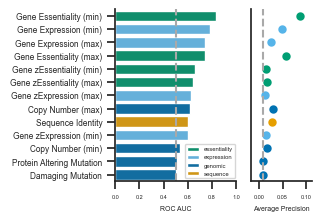

In [9]:
def plot_roc_pr(pred_df):
    sns.set_theme(style="ticks")

    f, ax = plt.subplots(ncols=2, nrows=1, figsize=(3.25, 2.25), sharey=True, gridspec_kw={'width_ratios': [2, 1]})
    
    colors = ["#009E73", "#56B4E9", '#0072B2', "#E69F00"]
    #colors = ["#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF"]56B4E9
    sns.set_palette(sns.color_palette(colors))

    sns.barplot(data=pred_df, x='mean_roc_auc', y='label', hue='category', palette=colors, saturation=0.8, dodge=False, ax=ax[0])
    ax[0].set_xlabel('ROC AUC', size=5) 
    ax[0].set_ylabel('')
    ax[0].set_xlim(0, 1)
    ax[0].tick_params('x', labelsize=4)
    ax[0].tick_params('y', labelsize=6)
    ax[0].axvline(x=0.5, linestyle='--', color='darkgrey')
    ax[0].legend(loc='lower right', fontsize=4.25, bbox_to_anchor=(1.02, 0))
    #ax[0].legend().remove()

    sns.pointplot(data=pred_df, x='avg_precision', y='label', hue='category', palette=colors,
                  dodge=False, markers='o', linestyles='none', errorbar=None, ax=ax[1])
    for line in plt.gca().lines:
        line.set_markersize(4)
    ax[1].set_xlabel('Average Precision', size=5) 
    ax[1].set_ylabel('')
    ax[1].set_xlim(pred_df['avg_precision'].min()-0.025, pred_df['avg_precision'].max()+0.025)
    
    # Remove y-ticks for ax[1]
    ax[1].tick_params('y', left=False, labelleft=False)
    ax[1].tick_params('x', labelsize=4)
    ax[1].axvline(x=0.0087, linestyle='--', color='darkgrey')
    ax[1].legend().remove()

    # Remove top and right borders
    sns.despine(ax=ax[0], top=True, right=True)
    sns.despine(ax=ax[1], top=True, right=True)

    plt.tight_layout(pad=0.7)
    #plt.show()
    #plt.savefig(figure_path_b, bbox_inches="tight", dpi=300)

plot_roc_pr(pred_df)

### Box Plot

In [10]:
box_feature = ['rMaxExp_A1A2', 'zMaxExp_A1A2', 'min_ranked_A1A2', 'z_min_ranked_A1A2', 'max_cn', 'max_seq_id']
box_labels = ['Gene Expression (max)', 'Gene zExpression (max)', 'Gene Essentiality (min)', 'Gene zEssentiality (min)', 'Copy Number', 'Sequence Identity']

display(dict(zip(box_feature, box_labels)))

{'rMaxExp_A1A2': 'Gene Expression (max)',
 'zMaxExp_A1A2': 'Gene zExpression (max)',
 'min_ranked_A1A2': 'Gene Essentiality (min)',
 'z_min_ranked_A1A2': 'Gene zEssentiality (min)',
 'max_cn': 'Copy Number',
 'max_seq_id': 'Sequence Identity'}

In [11]:
def draw_signif_line(ax, x0, x1, y, pval, hd=20):
    """Draws a significance line between two box plots."""
    h = y / hd
    if pval < 0.0001: 
        text = '$p$=%.1e' % pval
    else: 
        text = '$p$=%.4f' % pval
    ax.plot([x0, x0, x1, x1], [y + h, y + 2 * h, y + 2 * h, y + h], lw=0.8, c='#666')
    ax.text((x0 + x1) * .5, y + 2.5 * h, text, ha='center', va='bottom', color='#666', fontsize=5)


In [12]:
def compute_upper_whisker(df, feature):
    """Computes the upper whisker of a box plot for a given feature."""
    Q1 = df[feature].quantile(q=0.25)
    Q3 = df[feature].quantile(q=0.75)
    IQR = Q3 - Q1
    return df[df[feature] <= (Q3 + 1.5 * IQR)][feature].max()

In [13]:
def draw_cont_graph(df, feature, target_column, ax, label=None, fliers=True, show_points=True, draw_signif=True, hd=20):
    # Define the color palette based on feature names
    color_mapping = {
        'rMaxExp_A1A2': '#56B4E9',
        'zMaxExp_A1A2': '#56B4E9',
        'min_ranked_A1A2': '#009E73',
        'z_min_ranked_A1A2': '#009E73',
        'max_cn': '#0072B2',
        'max_seq_id': '#E69F00'
    }
    
    # Set the colors for False and True based on the feature
    true_color = color_mapping.get(feature, '#8491B4FF')  # default to original color if feature not in mapping
    my_pal = {False: "white", True: true_color}

    # Calculate the counts of SL and not_SL
    count_SL = (df[target_column] == True).sum()
    count_not_SL = (df[target_column] == False).sum()
    
    sns.despine(top=True, right=True, left=False, bottom=False)
    sns.boxplot(y=feature, x=target_column, hue=target_column, data=df, ax=ax, linewidth=0.8, saturation=0.8, 
                showfliers=False, showmeans=False, palette=my_pal, order=[False, True],  
                medianprops={'color':'black', 'linewidth':0.8},
                boxprops={'edgecolor':'black', 'alpha':0.85},)
    
    ax.set_ylabel(label if label else feature, fontsize=5.75)
    ax.set_xlabel('')
    ax.set_xticks([0, 1])
    ax.set_xticklabels([f'not_SL \n(n={count_not_SL})', f'SL \n(n={count_SL})'])
    ax.tick_params(axis='y', rotation=0, labelsize=4)
    ax.legend().remove()

    #if show_points:
    #    sns.stripplot(y=feature, x=target_column, data=df, color='silver', ax=ax, alpha=0.7, size=2, zorder=0)
    #    ax.set_xlabel('')
    #    ax.legend().remove()

    if draw_signif:
        pval = stats.mannwhitneyu(df.loc[df[target_column] == True, feature], df.loc[df[target_column] == False, feature], alternative="two-sided")[1]
        upper_whisker = max(compute_upper_whisker(df.loc[df[target_column] == True], feature), compute_upper_whisker(df.loc[df[target_column] == False], feature))
        draw_signif_line(ax, 0, 1, upper_whisker + 0.05, pval, hd)


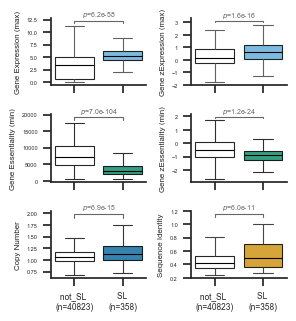

In [14]:
count_SL = (df_clean[target_column] == True).sum()
count_not_SL = (df_clean[target_column] == False).sum()

f, ax = plt.subplots(3, 2, figsize=(3, 3.25), sharex=True)  
ax = ax.flatten()

for i in range(len(box_feature)):
    draw_cont_graph(df_clean, box_feature[i], target_column, ax[i], label=box_labels[i])

# Remove x-tick labels from all subplots except for the second row (indices 2 and 3)
#for i in range(len(ax)):
#    if i != 3 and i != 4:
#        ax[i].set_xticklabels([])

# Set the x-tick labels for the subplot at index 3 (second row, second column)
ax[4].set_xticks([0, 1])
ax[4].set_xticklabels([f'not_SL \n(n={count_not_SL})', f'SL \n(n={count_SL})'], fontsize=6)

ax[5].set_xticks([0, 1])
ax[5].set_xticklabels([f'not_SL \n(n={count_not_SL})', f'SL \n(n={count_SL})'], fontsize=6)

#f.delaxes(ax[-1])
plt.tight_layout(pad=0.7)
#f.savefig(figure_path_a, bbox_inches="tight", dpi=300)
#plt.show()